# Localization - Line Map - SMC Move

In [1]:
display(HTML("<style>.rendered_html.text_cell_render {max-width:700px; }</style>"));

HTML{String}("<style>.rendered_html.text_cell_render {max-width:700px; }</style>")

In [2]:
#nbx
push!(LOAD_PATH, "src");
using BenchmarkTools;
using Colors, Plots;
col = palette(:default);
(cgrad::PlotUtils.ContinuousColorGradient)(xs::Vector{Vector{Float64}}) = [cgrad[x] for x in xs];
(cgrad::PlotUtils.ContinuousColorGradient)(m::Matrix{Float64}) = reshape(cgrad[m[:]], size(m));
using Gen
using GridSlam
using Geometry
using MyUtils

Base.Vector(p::Pose) = [p.x;p.hd]

In [3]:
include("src/unpack_data.jl");

Loading `data/data_3.jld2` ...

	_segs 	Vector{Segment}
	_xs 	Vector{Vector{Float64}}
	_hds 	Vector{Float64}
	_ps 	Vector{Pose}
	_dxs 	Vector{Vector{Float64}}
	_dhds 	Vector{Float64}
	_us 	Vector{Tuple{Vector{Float64}, Float64}}
	_as 	Vector{Float64}
	_zs 	Vector{Any}
	_ss 	Vector{Vector{Measurement}}
	_fov 	Float64
	_zmax 	Int64
	_T 	Int64

To take a look call `glimpse_at_data(_segs, _ps, _ss)`


In [4]:
_fov/2π*360, length(_as), _zmax, _as[1] != _as[end], _zs[1] != _zs[end]

(360.0, 360, 20, true, true)

## Utils

In [5]:
yxlims(x::Vector{Float64},w::Number) = Dict(
    :xlim=>(x[1]-w, x[1]+w), 
    :ylim=>(x[2]-w, x[2]+w)
);

## Distributions we need

In [6]:
#nbx
push!(LOAD_PATH, ENV["probcomp"]*"/Gen-Distribution-Zoo/src")
using GenDistributionZoo: ProductDistribution, diagnormal

mvuniform = ProductDistribution(uniform);
mvuniform(zeros(5), ones(5))

5-element Vector{Float64}:
 0.0005629966636424566
 0.012460857446779605
 0.5010174579272461
 0.4025492876975316
 0.40844652562967876

In [7]:
#nbx

# We use `anywhere` to model a sensor failure, in which case
# we want to ignore its measurement. This is a bit of a hack, 
# but works
struct Anywhere <: Distribution{Vector{Float64}} end
const anywhere = Anywhere()

Gen.logpdf(::Anywhere, x::Vector{Float64}) = 0.0
Gen.random(::Anywhere) = [Inf;Inf]
(::Anywhere)() = Gen.random(Anywhere())
Gen.has_output_grad(::Anywhere)    = false
Gen.has_argument_grads(::Anywhere) = ();

In [8]:
logpdf(anywhere, [Inf;Inf]),
logpdf(anywhere, rand(2))

(0.0, 0.0)

## Pose prior

In [9]:
#nbx --fname="src/pose_prior_model.jl"
_bb = bounding_box(_segs);

@doc """
    p = pose_prior_model(p=nothing, x_noise=0.25, hd_noise=22.5)

Model depends on global variable `_segs`.
"""
@gen function pose_prior_model(p=nothing, x_noise=0.25, hd_noise=22.5, bb=_bb)
    if p == nothing
        x  ~ mvuniform([bb[1]...],[bb[2]...])
        hd ~ uniform(0,2π)
    else
        x  ~ diagnormal(p.x, [x_noise,x_noise])
        hd ~ normal(p.hd, hd_noise/360*π)
    end
    return Pose(x,hd)
end;

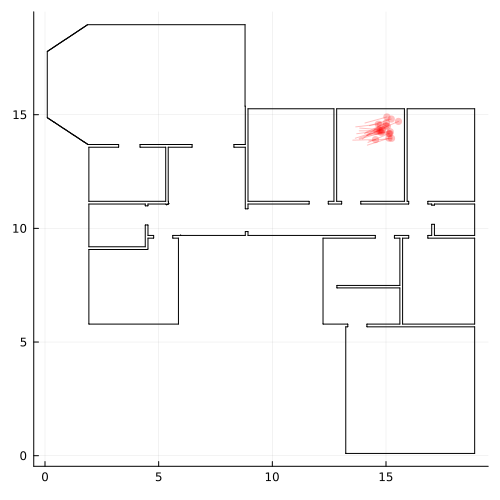

In [13]:
ps = [pose_prior_model(_ps[1]) for t=1:20]
# -----------------
myplot = plot(size=(500,500), aspect_ratio=:equal, legend=nothing)
plot!(_segs, c=:black)
scatter!.(ps, alpha=0.25)
myplot

## Motion model

In [14]:
#nbx --fname="src/motion_model.jl"
"""
    p′ = motion_model(p, u, x_noise=0.25, hd_noise=22.5)

Sample a new pose `p′` given the previous pose `p`, 
some control data `u = (dx, dhd)`, and noise levels
`x_noise` and `hd_noise` (in degrees).
"""
@gen function motion_model(p, u, x_noise=0.25, hd_noise=22.5)
    dx, dhd = u
    x   ~ diagnormal(p.x  + dx , [x_noise, x_noise])
    hd  ~ normal(p.hd + dhd, hd_noise/360*π)
    return p = Pose(x, hd)
end;

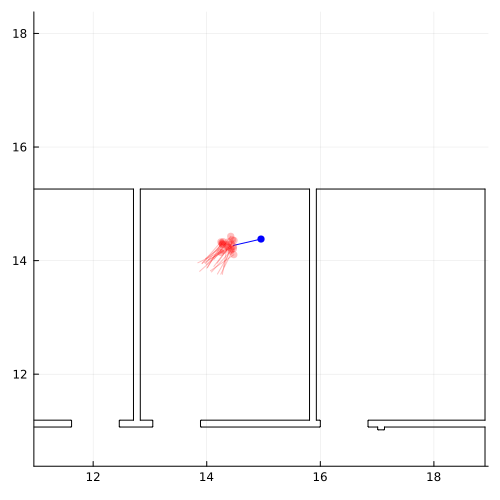

In [15]:
x_noise  = 0.1
hd_noise = 22.5;
t = 1
p = _ps[t]

ps = [motion_model(p, _us[1], x_noise, hd_noise) for t=1:20]
# -----------------
myplot = plot(size=(500,500), 
    xlim=(p.x[1]-4, p.x[1]+4), 
    ylim=(p.x[2]-4, p.x[2]+4),
    aspect_ratio=:equal, legend=nothing)
plot!(_segs, c=:black)
scatter!(p, r=0.5, c=:blue)
scatter!.(ps, r=0.5, alpha=0.25)
myplot

## SMC - Move

In [72]:
using CUDA

In [76]:
function logsumexp_cu(x, dim)
    c = maximum(x)
    return c .+ log.(sum(exp.(x .- c), dims=dim))
end

logsumexp_cu (generic function with 1 method)

### raycast

In [17]:
include("src/cuda_raycaster_line_map.jl");
segs_ = CuArray(stack(Vector.(_segs)))

# Todo: Change cast_v4! signature and put z_ in there 
#       and replace arg by num_a and fov....
function cast_cu(ps_::CuArray; blockdims=(16,16))
    n = size(segs_, 1)    
    m = size(ps_,1)
    z_ = Inf*CUDA.ones(m, n, 360)
    z_ = cast_v4!(segs_,ps_,z_; blockdims=blockdims)
    
    return z_
end

cast_cu (generic function with 1 method)

In [132]:
function pose_grid(p, k, delta_x, delta_hd)

    dx1_ = CUDA.collect(CUDA.range(-delta_x,  delta_x, k))
    dx2_ = CUDA.collect(CUDA.range(-delta_x,  delta_x, k))
    dhd_ = CUDA.collect(CUDA.range(-delta_hd/360*π, delta_hd/360*π,k))
    dx1_ = CuArray(dx1_)
    dx2_ = CuArray(dx2_)
    dhd_ = CuArray(dhd_)
    dx1_ = CUDA.repeat(dx1_,  1, k, k)
    dx2_ = CUDA.repeat(reshape(dx2_,1,k,1), k, 1, k)
    dhd_ = CUDA.repeat(reshape(dhd_,1,1,k), k, k, 1)

    p_ = CUDA.cat(dx1_,dx2_, dhd_, dims=4)
    p_ = reshape(p_, :,3)
    p_ = p_ .+ reshape(CuArray(Vector(p)),1,3)
    return p_
end

p = _ps[1]
delta_x  = 0.5
delta_hd = 10
k = 10
@btime pose_grid($p,$k,$delta_x,$delta_hd) samples=3 evals=3;

  156.126 μs (396 allocations: 20.44 KiB)


In [131]:
ps = Array(pose_grid(p, k, delta_x, delta_hd))
ps = reshape(ps, k,k,k,3)
ps[1,2,:,3] == ps[2,2,:,3]
cos()

true

### sliding window

In [42]:
function slw_kernel!(x, w::Int, y)
    
    m = 2*w + 1
    
    @assert ndims(y) == 3
    @assert ndims(x) == ndims(y) - 1
    @assert size(x,1) == size(y,1)
    @assert size(x,2) == size(y,2)
    @assert size(y,3) == m
    
    ix = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    iy = (blockIdx().y - 1) * blockDim().y + threadIdx().y
    iz = (blockIdx().z - 1) * blockDim().z + threadIdx().z
    sx = gridDim().x * blockDim().x
    sy = gridDim().y * blockDim().y
    sz = gridDim().z * blockDim().z
        
    for j_pose = ix:sx:size(y,1), j_obs = iy:sy:size(y,2), j_mix = iz:sz:size(y,3)
        offset = j_mix-1-w
        j_mix_adj = mod(j_obs + offset - 1 , size(x,2)) + 1
        @inbounds y[j_pose, j_obs, j_mix] = x[j_pose, j_mix_adj]
    end
    return
end

function slw_cu!(x::CuArray, w::Int; blockdims=(8,8,4))
    
    k = size(x, 1)
    n = size(x, 2)
    m = 2*w+1
    
    y = CUDA.ones(k,n,m)
    griddims = cuda_grid((k,n,m), blockdims)
    CUDA.@sync begin
        @cuda threads=blockdims blocks=griddims slw_kernel!(x, w, y)
    end
    
    return y
end

slw_cu! (generic function with 1 method)

In [48]:
w = 1
zs = stack([collect(1:5)*10^(i-1) for i=1:10])
zs_ = CuArray(zs)
zs_tilde_ = slw_cu!(zs_,w)

println(size(zs_))
println(size(zs_tilde_))

zs_tilde_[2,:,:]

(10, 5)
(10, 5, 3)


5×3 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
 50.0  10.0  20.0
 10.0  20.0  30.0
 20.0  30.0  40.0
 30.0  40.0  50.0
 40.0  50.0  10.0

### y_tilde

In [44]:
polar_inv_cu(z::CuArray,a::CuArray) = cat(z.*cos.(a), z.*sin.(a), dims=ndims(a)+1);

In [60]:
a_ = CuArray(range(0,π, 5))
a_tilde_ = slw_cu!(reshape(a_,1,:),w)

println(size(zs_tilde_), size(a_tilde_))
y_tilde_ = polar_inv_cu(zs_tilde_, a_tilde_)
size(y_tilde_)

(10, 5, 3)(1, 5, 3)


(10, 5, 3, 2)

In [61]:
a_ = CuArray(_as)

function get_ys_tilde_cu(zs_::CuArray, w::Int)    
    zs_tilde_ = slw_cu!(zs_, w)
    as_tilde_ = slw_cu!(reshape(a_,1,:), w)
    
    ys_tilde_ = polar_inv_cu(zs_tilde_, as_tilde_)
    
    return ys_tilde_
end

get_ys_tilde_cu (generic function with 1 method)

In [67]:
w = 5
ys_tilde_ = get_ys_tilde_cu(zs_, w);  
size(ys_tilde_)

(1000, 360, 11, 2)

### sensor_smc_logpdf_cu

In [62]:
function gaussian_logpdf(x, mu, sig)
    d = (x .- mu).^2 ./ sig.^2
    log_p = - log.(sqrt.(sig * 2 * π)) .- 1/2 * d
    return log_p
end;

In [79]:
function sensor_smc_logpdf_cu(x::CuArray, ys_tilde::CuArray, sig, dropout)

    n = size(ys_tilde,2)
    m = size(ys_tilde,3)
    
    xs = reshape(x, 1, n, 1, 2)
    
    # Compute 1D Gaussians - (n,m,2)
    # Convert to 2D gausians - (n,m)
    # Convert to mixture of m 2D gausians (GM) - (n,)
    # Convert to mixture of `GM` and `anywhere` (D) - (n,)
    # Convert to Product of D's - ()
    log_p = gaussian_logpdf(xs, ys_tilde, sig)
    log_p = sum(log_p, dims=4)[:,:,:,1] 
    log_p = logsumexp_cu(log_p .- log(m), 3)[:,:,1] 
    log_p_or_any = log.((1-dropout)*exp.(log_p) .+ dropout*1.0)
    log_p = sum(log_p_or_any ,dims=2)[:,1]
    return log_p
end

sig=1.0
dropout=0.1
x = stack(polar_inv(_zs[1],_as))
x_ = CuArray(x)
sensor_smc_logpdf_cu(x_, ys_tilde_, sig, dropout)
# x_ = CuArray(x)
@btime sensor_smc_logpdf_cu($x_, $ys_tilde_, sig, dropout) samples=3 evals=3;

  1.375 ms (695 allocations: 40.31 KiB)


### Put it together

In [154]:
function Plots.plot!(p::Pose; r=0.5, args...)
    plot!([p.x, p.x + r*unit_vec(p.hd)]; args...)
end

function Plots.plot!(ps::Vector{Pose}, cs::Vector{RGBA{Float64}}; r=0.5, args...)
    for (p,c) in zip(ps,cs)
        plot!([p.x, p.x + r*unit_vec(p.hd)];c=c, args...)
    end
end

In [178]:
perturb(p::Pose, x_noise, hd_noise) = Pose(
    p.x + [normal(0,x_noise); normal(0,x_noise)], 
    p.hd + normal(0, hd_noise/360*2π))

perturb (generic function with 1 method)

In [422]:
@transform transform_pose (t1) to (t2) begin
    x = @read(t1[:x], :continuous)
    hd = @read(t1[:hd], :continuous)
    @write(t2[:pose_vex], [x;hd], :continuous)
end

@transform transform_pose_inv (t1) to (t2) begin
    p = @read(t1[:p], :continuous)
    @write(t2[:x], [p[1:2]], :continuous)
    @write(t2[:hd], [p[3]], :continuous)
end

TraceTransformDSLProgram(var"#224###transform_pose_inv_fn!#1399", nothing)

In [443]:
function grid_proposals(p, x, sig, dropout, delta_k, delta_x, delta_hd)

    ps_ = pose_grid(p, delta_k, delta_x, delta_hd)
    zs_ = cast_cu(ps_; blockdims=(16,16));
    ys_tilde_ = get_ys_tilde_cu(zs_, w);



    x_ = CuArray(x)
    log_p_ = sensor_smc_logpdf_cu(x_, ys_tilde_, sig, dropout);
    
    # Sort by log prob
    ps = [Pose(p[1:2],p[3]) for p in eachrow(Array(ps_))];
    log_p = Array(log_p_)
        
    perm  = sortperm(log_p)
    log_p = log_p[perm]
    ps    = ps[perm]
    
    return ps, log_p
end

grid_proposals (generic function with 1 method)

In [445]:
function filter_infs(ps, log_p)
    good = log_p .!= -Inf
    return ps[good], log_p[good]
end

filter_infs (generic function with 1 method)

In [464]:
clamp!(rand(2), 0.09, 0.1)

2-element Vector{Float64}:
 0.1
 0.1

  0.004377 seconds (1.59 k allocations: 94.000 KiB)
-1268.5459970481836
-768.5745761173065 


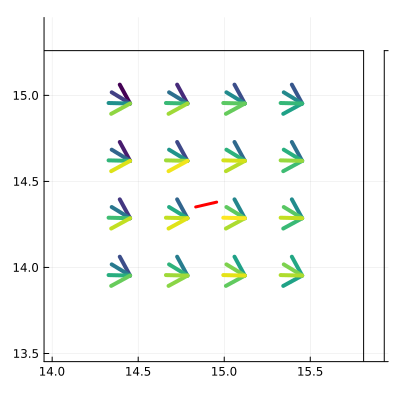

In [492]:
t=1
p0 = _ps[t]
x = stack(polar_inv(_zs[t],_as))

p = perturb(p0, delta_x/delta_k, 20)

w   = 50
sig = 0.5
dropout = 1e-2
delta_x  = 0.5
delta_hd = 90
delta_k  = 4
@time ps, log_p = grid_proposals(p, x, sig, dropout, delta_k, delta_x, delta_hd);
ps, log_p = filter_infs(ps, log_p)
println("$(minimum(log_p))\n$(maximum(log_p)) ")

# clamp!(log_p, -4_000.0, 0) 
cs = peak_to_peak(log_p)
# cs = log_p .- minimum(log_p)
# cs = cs/maximum(cs)



# ---------------
mypl = plot(size=(400,400), legend=nothing; yxlims(p.x,1)..., aspect_ratio=:equal)
plot!(_segs, c=:black)
# scatter!([p.x .+ 0.1*[cos(p.hd);sin(p.hd)] for p in ps], zcolor=log_p)
plot!(ps, cgrad(:viridis)[cs], r=0.125, linewidth=4)
plot!(p0,c=:red, r=0.125, linewidth=3)
mypl

  0.001661 seconds (1.50 k allocations: 85.469 KiB)
  0.004239 seconds (1.89 k allocations: 129.648 KiB)


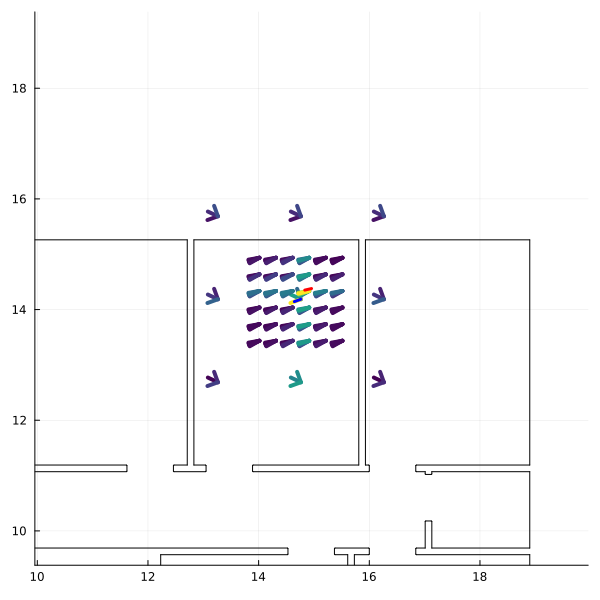

In [557]:
t=1
p0 = _ps[t]
x = stack(polar_inv(_zs[t],_as))

# ---------------
mypl = plot(size=(600,600), legend=nothing; yxlims(p0.x,5)..., aspect_ratio=:equal)

w   = 1
sig = 0.1
dropout = 1e-12
delta_x  = 1.5
delta_hd = 90
delta_k  = 3
p = perturb(p0, delta_x/(delta_k-1), 20)
@time ps, log_p = grid_proposals(p, x, sig, dropout, delta_k, delta_x, delta_hd);
ps, log_p = filter_infs(ps, log_p)

cs = peak_to_peak(log_p)
plot!(ps, cgrad(:viridis)[cs], r=0.2, linewidth=4)


w   = 5
sig = 0.05
dropout = 1e-2
delta_x  = delta_x/(delta_k-1)
delta_hd = 20
delta_k  = 6
p1 = ps[end]
@time ps, log_p = grid_proposals(p1, x, sig, dropout, delta_k, delta_x, delta_hd);
ps, log_p = filter_infs(ps, log_p)


# scatter!([p.x for p in ps], c=:gray)

cs = peak_to_peak(log_p)
# cs = log_p .- minimum(log_p)
# cs = cs/maximum(cs)




plot!(_segs, c=:black)
# scatter!([p.x .+ 0.1*[cos(p.hd);sin(p.hd)] for p in ps], zcolor=log_p)
plot!(ps, cgrad(:viridis)[cs], r=0.2, linewidth=4)
plot!(p0,c=:red, r=0.125, linewidth=3)
plot!(p1,c=:blue, r=0.125, linewidth=3)
mypl

In [415]:
p0 = _ps[1]

x = stack(polar_inv(_zs[1],_as))

w   = 1
sig = .1


delta_x  = 0.5
delta_hd = 90
# delta_x  = 0.1
# delta_hd = 10
delta_k = 4

p = perturb(p0,delta_x/delta_k, 20)
ps_ = pose_grid(p, delta_k, delta_x, delta_hd)
zs_ = cast_cu(ps_::CuArray; blockdims=(16,16));
ys_tilde_ = get_ys_tilde_cu(zs_, w);


dropout = 0.0001
x = stack(polar_inv(_zs[1],_as))
x_ = CuArray(x)
log_p_ = sensor_smc_logpdf_cu(x_, ys_tilde_, sig, dropout);

In [416]:
log_p = Array(log_p_)
ps = [Pose(p[1:2],p[3]) for p in eachrow(Array(ps_))];
xs = [polar_inv(Array(z),_as) for z in eachrow(Array(zs_))];
length(ps)

64

In [417]:
println(sum(log_p .== -Inf))
ps = ps[log_p .!= -Inf]
xs = xs[log_p .!= -Inf]
log_p = log_p[log_p .!= -Inf];

0


-3260.5275726154478


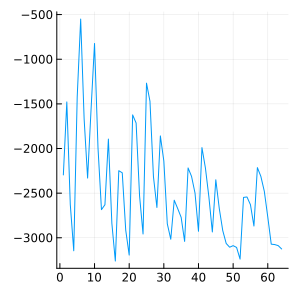

In [418]:
println(minimum(log_p))
# -----------------
plot(size=(300,300), legend=nothing)
plot!(log_p)

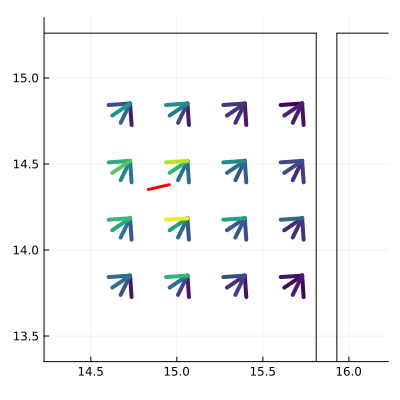

In [419]:
perm = sortperm(log_p)
log_p = log_p[perm]
ps    = ps[perm]
cs = peak_to_peak(log_p)

# ---------------
mypl = plot(size=(400,400), legend=nothing; yxlims(p.x,1)..., aspect_ratio=:equal)
plot!(_segs, c=:black)
# scatter!([p.x .+ 0.1*[cos(p.hd);sin(p.hd)] for p in ps], zcolor=log_p)
plot!(ps, cgrad(:viridis)[cs], r=0.125, linewidth=4)
plot!(p0,c=:red, r=0.125, linewidth=3)
mypl

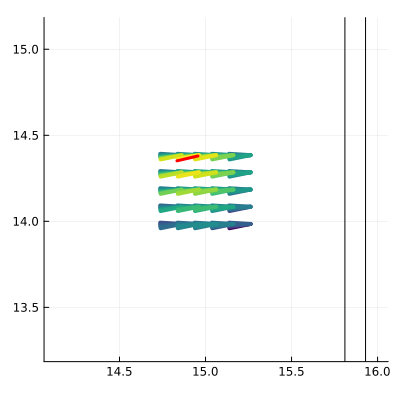

In [420]:


w = 10
delta_x  = 0.2
delta_hd = 15
# delta_x  = 0.1
# delta_hd = 10
delta_k = 5

p = ps[end]
ps_ = pose_grid(p, delta_k, delta_x, delta_hd)
zs_ = cast_cu(ps_::CuArray; blockdims=(16,16));
ys_tilde_ = get_ys_tilde_cu(zs_, w);

sig = .1
dropout = 0.0001
x = stack(polar_inv(_zs[1],_as))
x_ = CuArray(x)
log_p_ = sensor_smc_logpdf_cu(x_, ys_tilde_, sig, dropout);

log_p = Array(log_p_)
ps = [Pose(p[1:2],p[3]) for p in eachrow(Array(ps_))];
xs = [polar_inv(Array(z),_as) for z in eachrow(Array(zs_))];


perm = sortperm(log_p)
log_p = log_p[perm]
ps    = ps[perm]
cs = peak_to_peak(log_p)


# ---------------
mypl = plot(size=(400,400), legend=nothing; yxlims(p.x,1)..., aspect_ratio=:equal)
plot!(_segs, c=:black)
# scatter!([p.x .+ 0.1*[cos(p.hd);sin(p.hd)] for p in ps], zcolor=log_p)
plot!(ps, cgrad(:viridis)[cs], r=0.125, linewidth=4)
plot!(p0,c=:red, r=0.125, linewidth=3)
mypl

In [412]:
function pose_proposal(p, w::Int, r::Int, delta_x=0.2, delta_hd=10)
    delta_hd = delta_hd/360*π
    
    ps_ = pose_grid(p, r, delta_x,delta_hd)
    zs_ = cast_cu(ps_; blockdims=(16,16))
    
    k = size(zs_,1)
    n = size(zs_,2)
    m = 2*w+1
    
    y_tildes_ = CUDA.ones(k,n,m,2)
    for ik=1:k
        y_tildes_[ik,:,:,:] = get_y_tilde_cu(zs_[ik,:], w)
    end
#     get_y_tilde_cu(zs_[1,:], w)
    
end

@btime pose_proposal(p, 7, 10, delta_x, delta_hd) samples=1 evals=1;

LoadError: UndefVarError: get_y_tilde_cu not defined

## SLAM Model

General structure:
```julia
motion_model(p::Pose, u::Control, motion_args...)
sensor_model(p::Pose, m::MAP, sensor_args...)
```
Here:
```julia
sensor_model(p::Pose, sensor_args...)
```

```julia

    prior     chain 
     0          1        2          t-1

               u[1] --- u[2]  ...  u[t-1]
                |        |          |
    p[1] - - - p[2] --- p[3]  ...  p[t]
     |          |        |          |
    y[1]       y[2]     y[3]  ...  y[t] 
```

In [96]:
#nbx
@gen function slam_kernel(t, state, us, x_noise, hd_noise, w, s_noise, dropout)
    
        p,_ = state
        u = us[t]
    
        p  = {:pose}   ~ motion_model(p, u, x_noise, hd_noise)
        x, = {:sensor} ~ sensor_model_GPU(p, w, s_noise, dropout) # GPU accelerated
        
    return (p, x)
end

slam_chain = Gen.Unfold(slam_kernel)
Gen.@load_generated_functions

In [97]:
#nbx
"""
    [(p,z),...] = static_slam_model(T, segs_, a_, us, motion_noise, sensor_noise, dropout, inds)

Static SLAM model ...
"""
@gen (static) function static_slam_model(T, us, 
        p0, x0_noise, hd0_noise,  
        x_noise, hd_noise, 
        w, s_noise, dropout)
    
    # Start the Markov chain; 
    # No motion, just the prior
    p  = { :pose   } ~ pose_prior_model(p0, x0_noise, hd0_noise)
    x, = { :sensor } ~ sensor_model_GPU(p, w, s_noise, dropout) # GPU accelerated
    
    # Unfold the MArkov chain
    chain ~ slam_chain(T, (p, nothing), us, 
        x_noise, hd_noise, 
        w, s_noise, dropout)
    
    return [(p,x);chain]
end

Gen.@load_generated_functions

In [98]:
foldr(=>,[:x, :y, :z]) 

:x => (:y => :z)

In [241]:
get_pose(tr,t) = tr[][t][1]
get_first_pose(tr) = get_pose(tr,1)

get_x(tr,t) = tr[][t][2]
get_first_x(tr) = get_x(tr,1)

get_first_x (generic function with 1 method)

In [100]:
function Plots.plot!(p::Pose; r=0.5, args...)
    plot!([p.x, p.x + r*unit_vec(p.hd)]; args...)
end

function Plots.plot!(ps::Vector{Pose}, cs::Vector{RGBA{Float64}}; r=0.5, args...)
    for (p,c) in zip(ps,cs)
        plot!([p.x, p.x + r*unit_vec(p.hd)];c=c, args...)
    end
end

In [105]:
function constraints(t::Int)
    ch = choicemap()
    if t==0
        addr  = :sensor => :x
    else
        addr  = :chain => t => :sensor => :x
    end
    n = length(_zs[t+1])
    x = polar_inv(_zs[t+1],_as)
    ch[addr] = x
    return ch
end

constraints (generic function with 1 method)

In [417]:
T = 0

p0 = _ps[1]
x0_noise = .5
hd0_noise = 15.

x_noise = 0.1
hd_noise = 22.5

wind = 360
s_noise = 0.5
dropout = 0.01

ch = constraints(0)

args = (
    T, _us,         
    p0, x0_noise, hd0_noise, # Pose prior model
    x_noise, hd_noise,       # Motion model
    wind, s_noise, dropout      # Sensor model
)

@time tr, w = generate(static_slam_model, args, ch);

  0.001489 seconds (1.58 k allocations: 108.906 KiB)


In [418]:
N = 1_000
@time trs, ws, lml = importance_sampling(static_slam_model, args, ch, N);

trs = trs[ws .!= -Inf]
ws  = ws[ws .!= -Inf]

scores = get_score.(trs);
perm = sortperm(ws); 
trs = trs[perm]; 
ws = ws[perm]; 
scores=scores[perm];

  1.264802 seconds (1.65 M allocations: 108.777 MiB, 12.14% gc time)


In [419]:
sum(ws .== NaN),sum(ws .== -Inf), sum(scores .== NaN), sum(scores .== -Inf)

(0, 0, 0, 0)

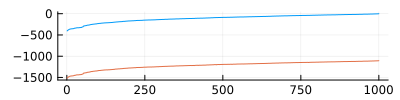

In [420]:
plot(size=(400,100), legend=nothing)
plot!(ws)
plot!(scores)

    w = 360
    s_noise = 0.5
    dropout = 0.01



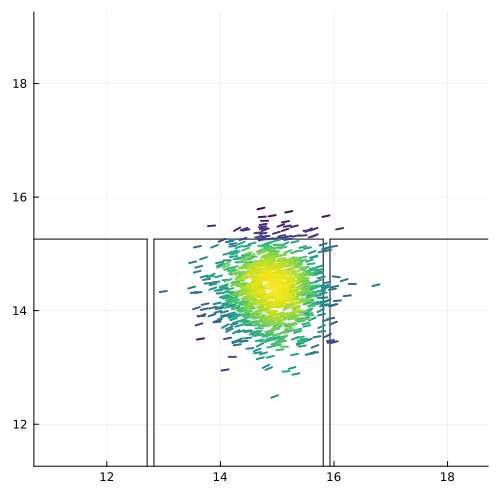

In [421]:
println("""
    w = $(wind)
    s_noise = $(s_noise)
    dropout = $(dropout)
""")
perm = sortperm(exp.(ws)); trs = trs[perm]; ws = ws[perm];
p = ps[1]
ps = get_pose.(trs, 1)
cs = peak_to_peak(ws)
# ------
myplot = plot(size=(500,500),
    xlim=(p.x[1]-4, p.x[1]+4), 
    ylim=(p.x[2]-4, p.x[2]+4),
    aspect_ratio=:equal, legend=nothing)
plot!(_segs, c=:black)
# scatter!(y.*p)
plot!(ps, cgrad(:viridis)[cs], r=0.125, linewidth=2)
myplot

In [449]:
function plot_tr(tr; size=(200,200), r=1.0)
    p = get_first_pose(tr)
    x = get_first_x(tr)
    
    println(Vector(p) - Vector(_ps[1]))
    
    myplot = plot(size=size,
    xlim=(p.x[1]-4, p.x[1]+4), 
    ylim=(p.x[2]-4, p.x[2]+4),
    aspect_ratio=:equal, legend=nothing)
    plot!(_segs, c=:black)
    scatter!(_ps[1],  r=r, c=:red)
    scatter!(p, r=r, c=col[1])
    scatter!(x.*p, c=col[1], markerstrokewidth=0, alpha=.2, markersize=2, marker=:o)
    myplot
end

plot_tr (generic function with 1 method)

[-0.021418039950658496, 0.0823731805857566, -0.04839708297671441]


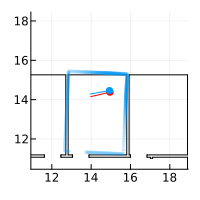

In [450]:
tr = trs[end]
plot_tr(tr; size=(200,200))

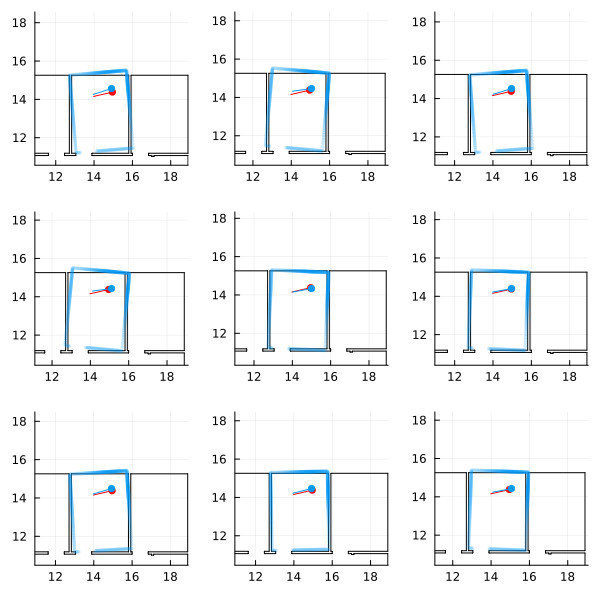

In [424]:
plot([plot_tr(tr; size=(200,200)) for tr in trs[end-9+1:end]]..., layout=(3, 3), size=(600,600))

## Particle Filter

In [425]:
include("src/gen_utils.jl")

argdiffs (generic function with 1 method)

In [474]:
p0 = _ps[1]
x0_noise = .5
hd0_noise = 15.

x_noise = 0.1
hd_noise = 22.5

wind = 50
s_noise = 0.5
dropout = 0.01

ch = constraints(0)

args = (_us,         
    p0, x0_noise, hd0_noise, # Pose prior model
    x_noise, hd_noise,       # Motion model
    wind, s_noise, dropout      # Sensor model
)
diffs = argdiffs([1; fill(0, length(args))])

N = 1_000
state = initialize_particle_filter(static_slam_model, (0, args...), ch, N);

println(minimum(state.log_weights), "  ,  " ,maximum(state.log_weights))


PS = Array{Pose,2}(undef, N, T)
WS = Array{Float64,2}(undef, N, T)
T = 10
for t=1:T
    ch = constraints(t)
    

    for i in 1:N
        PS[i,t] = state.traces[i][][end][1]
        WS[i,t] = state.log_weights[i]
    end
    
    b = maybe_resample!(state, ess_threshold=50)
#     b = maybe_resample!(state, ess_threshold=4_500)
    println(b)
    @time particle_filter_step!(state, (t, args...), diffs, ch) 
#     println(minimum(state.log_weights), "  ,  " ,maximum(state.log_weights))
#     println(minimum(get_score.(state.traces)), " ,  ", maximum(get_score.(state.traces)))
end

-1534.4881379123856  ,  -741.7543714130903
true
  0.992230 seconds (1.65 M allocations: 112.582 MiB)
true
  1.451621 seconds (1.83 M allocations: 118.102 MiB, 10.49% gc time)
true
  0.991593 seconds (1.65 M allocations: 112.658 MiB)
true
  1.005402 seconds (1.65 M allocations: 112.673 MiB)
true
  1.449856 seconds (1.83 M allocations: 118.179 MiB, 10.94% gc time)
true
  0.990738 seconds (1.65 M allocations: 112.720 MiB)
true
  1.045131 seconds (1.65 M allocations: 112.750 MiB)
true
  1.508046 seconds (1.83 M allocations: 118.240 MiB, 9.75% gc time)
true
  1.023345 seconds (1.65 M allocations: 112.796 MiB)
true
  1.048083 seconds (1.65 M allocations: 112.811 MiB)


[-0.069723914320857, 0.11625690967840718, 0.05617277504309337]


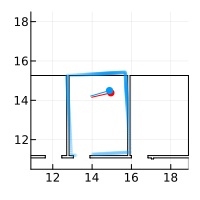

In [470]:
trs = state.traces
ws  = state.log_weights;

trs = trs[ws .!= -Inf]
ws  = ws[ws .!= -Inf]
scores = get_score.(trs)

perm = sortperm(ws); 
trs = trs[perm]; 
ws = ws[perm]; 
scores=scores[perm];

tr = trs[end]
plot_tr(tr; size=(200,200))

    w = 50
    s_noise = 0.5
    dropout = 0.01



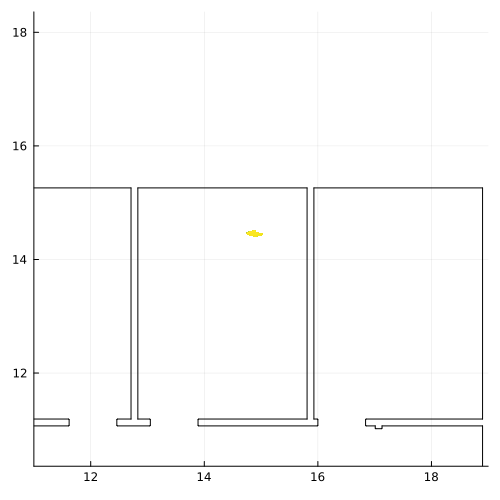

In [471]:
println("""
    w = $(wind)
    s_noise = $(s_noise)
    dropout = $(dropout)
""")
p = ps[1]
ps = get_pose.(trs, 1)
cs = peak_to_peak(ws)
# ------
myplot = plot(size=(500,500),
    xlim=(p.x[1]-4, p.x[1]+4), 
    ylim=(p.x[2]-4, p.x[2]+4),
    aspect_ratio=:equal, legend=nothing)
plot!(_segs, c=:black)
# scatter!(y.*p)
plot!(ps, cgrad(:viridis)[cs], r=0.125, linewidth=2)
myplot

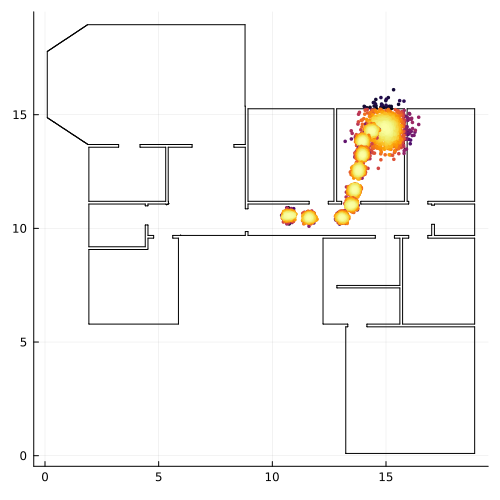

In [484]:


myplot = plot(size=(500,500),
#     xlim=(p.x[1]-4, p.x[1]+4), 
#     ylim=(p.x[2]-4, p.x[2]+4),
    aspect_ratio=:equal, legend=nothing)
plot!(_segs, c=:black)

# for i = 1:length(trs)
#     perm = sortperm(WS[i,:])
#     scatter!([p.x for p in PS[i,:]], zcolor=WS[i,:])
# end

for t = 1:T
    perm = sortperm(WS[:,t])
    scatter!([p.x for p in PS[perm,t]], zcolor=peak_to_peak(WS[perm,t]), markerstrokewidth=0, markersize=2)
end
myplot